In [1]:
from google.cloud import bigquery
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from collections import Counter
import datetime as dt

If you want interactive charts, comment or delete this cell. Then, restart the kernel and run the cells again.

In [2]:
import plotly.io as pio
pio.renderers.default = 'png'


In [3]:
client = bigquery.Client()
dataset_ref = client.dataset("thelook_ecommerce", project="bigquery-public-data")


## Conversion Rates Analysis

#### Scope Definition: 
- Primary Question: Which traffic source contribute the most to the business conversion rates?
- Identify any potential seasonal, trending patterns over time.

#### Constraint Identification:
- These data can't be used to infer or predict detailed users behavior or sales related metrics.

In [5]:
query = """
WITH ordered_events AS (
  SELECT
    session_id,
    event_type,
    traffic_source,
    created_at,
    ROW_NUMBER() OVER (PARTITION BY session_id ORDER BY created_at) AS event_order
  FROM
    `bigquery-public-data.thelook_ecommerce.events`
)
SELECT
  session_id,
  MIN(CASE WHEN event_type = 'home' THEN event_order END) AS home_order,
  MIN(CASE WHEN event_type = 'department' THEN event_order END) AS department_order,
  MIN(CASE WHEN event_type = 'product' THEN event_order END) AS product_order,
  MIN(CASE WHEN event_type = 'cart' THEN event_order END) AS cart_order,
  MIN(CASE WHEN event_type = 'purchase' THEN event_order END) AS purchase_order,
  ARRAY_AGG(event_type ORDER BY event_order) AS event_sequence,
  ARRAY_AGG(traffic_source ORDER BY event_order LIMIT 1)[OFFSET(0)] AS first_touch_source,
  MIN(created_at) AS timestamp
FROM
  ordered_events
GROUP BY
  session_id
"""

conversion_df = client.query(query).to_dataframe()
conversion_df.head()

,session_id,home_order,department_order,product_order,cart_order,purchase_order,event_sequence,first_touch_source,timestamp
0,0378302c-eb97-4e91-ac79-237c2e86f490,<NA>,<NA>,2,1,<NA>,"[cart, product, cancel]",Adwords,2024-10-16 15:57:00+00:00
1,05604253-ee02-4a01-b2ed-7a1f50ab6d46,1,2,3,5,4,"[home, department, product, purchase, cart]",Email,2024-05-06 04:48:01+00:00
2,14758a16-e6f8-4b31-b716-4140ffbb6f38,<NA>,<NA>,2,1,<NA>,"[cart, product, cancel]",YouTube,2022-03-17 00:16:00+00:00
3,230e6ff0-5c92-4cb7-930d-019cb81cbd9c,<NA>,<NA>,2,1,<NA>,"[cart, product, cancel]",Email,2025-05-23 17:58:00+00:00
4,26cc1a9f-2830-4537-9695-829e075fa777,<NA>,<NA>,2,1,<NA>,"[cart, product, cancel]",Email,2020-04-26 11:34:00+00:00


#### Data Cleaning
Clean, reformat the timestamp variable, and drop excessive columns.

In [6]:
dat = conversion_df.copy()

dat['timestamp'] = pd.to_datetime(dat['timestamp']).dt.tz_localize(None)
dat['date'] = dat['timestamp'].dt.date
dat['week'] = dat['timestamp'].dt.to_period('W').dt.start_time
dat['month'] = dat['timestamp'].dt.to_period('M').dt.start_time
dat['quarter'] = dat['timestamp'].dt.to_period('Q').dt.start_time

dat.head()

,session_id,home_order,department_order,product_order,cart_order,purchase_order,event_sequence,first_touch_source,timestamp,date,week,month,quarter
0,0378302c-eb97-4e91-ac79-237c2e86f490,<NA>,<NA>,2,1,<NA>,"[cart, product, cancel]",Adwords,2024-10-16 15:57:00,2024-10-16,2024-10-14,2024-10-01,2024-10-01
1,05604253-ee02-4a01-b2ed-7a1f50ab6d46,1,2,3,5,4,"[home, department, product, purchase, cart]",Email,2024-05-06 04:48:01,2024-05-06,2024-05-06,2024-05-01,2024-04-01
2,14758a16-e6f8-4b31-b716-4140ffbb6f38,<NA>,<NA>,2,1,<NA>,"[cart, product, cancel]",YouTube,2022-03-17 00:16:00,2022-03-17,2022-03-14,2022-03-01,2022-01-01
3,230e6ff0-5c92-4cb7-930d-019cb81cbd9c,<NA>,<NA>,2,1,<NA>,"[cart, product, cancel]",Email,2025-05-23 17:58:00,2025-05-23,2025-05-19,2025-05-01,2025-04-01
4,26cc1a9f-2830-4537-9695-829e075fa777,<NA>,<NA>,2,1,<NA>,"[cart, product, cancel]",Email,2020-04-26 11:34:00,2020-04-26,2020-04-20,2020-04-01,2020-04-01


In [7]:
dat.drop(columns=['home_order', 'department_order', 'product_order', 'cart_order'], inplace=True)
dat.describe()

,purchase_order,timestamp,week,month,quarter
count,182127.0,682127,682127,682127,682127
mean,7.176004,2022-09-13 16:16:18.444792,2022-09-10 06:39:21.783070208,2022-08-29 11:06:23.085847552,2022-07-29 12:39:38.660865792
min,3.0,2019-01-02 00:11:00,2018-12-31 00:00:00,2019-01-01 00:00:00,2019-01-01 00:00:00
25%,5.0,2021-02-03 14:20:00,2021-02-01 00:00:00,2021-02-01 00:00:00,2021-01-01 00:00:00
50%,7.0,2022-11-27 03:45:00,2022-11-21 00:00:00,2022-11-01 00:00:00,2022-10-01 00:00:00
75%,7.0,2024-06-03 08:51:18,2024-06-03 00:00:00,2024-06-01 00:00:00,2024-04-01 00:00:00
max,13.0,2025-07-02 18:56:33.539474,2025-06-30 00:00:00,2025-07-01 00:00:00,2025-07-01 00:00:00
std,2.791275,NaN,NaN,NaN,NaN


In [8]:
dat['session_id'].describe()

count                                   682127
unique                                  682127
top       0378302c-eb97-4e91-ac79-237c2e86f490
freq                                         1
Name: session_id, dtype: object

There seems to be no duplicate in this dataset.

#### Data Visualizations
Visualize the data

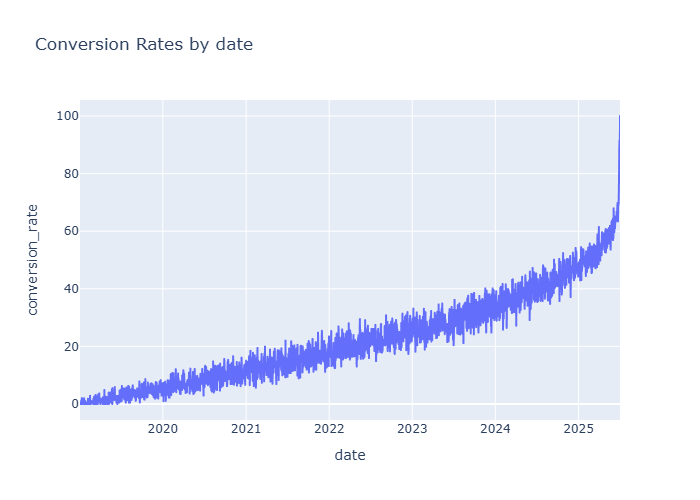

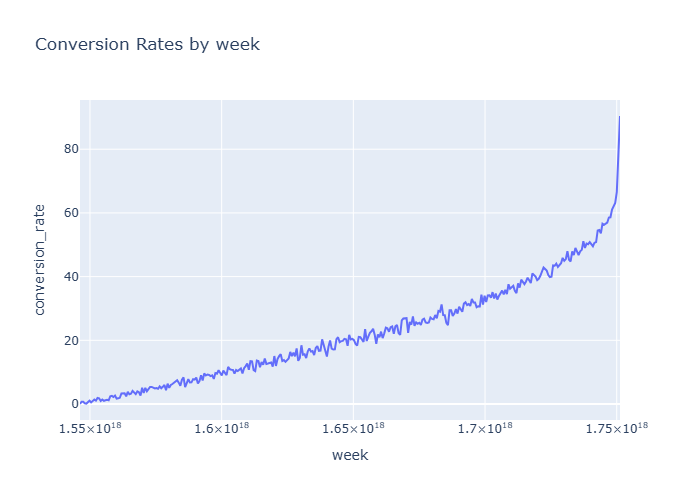

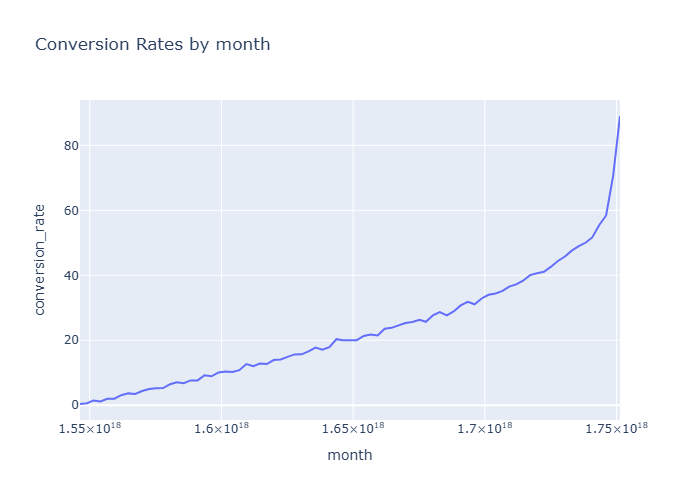

In [9]:
time_intervals = ['date', 'week', 'month']
time_intervals_stats = {}


for interval in time_intervals:
    stats = dat.groupby(interval).agg(
        total_sessions=('session_id', 'count'),
        purchases=('purchase_order', lambda x: x.notna().sum())
    ).reset_index()
    stats['conversion_rate'] = (stats['purchases'] / stats['total_sessions']) * 100
    fig_interval = px.line(stats, x=interval, y='conversion_rate',
                           title = f"Conversion Rates by {interval}")
    fig_interval.show()

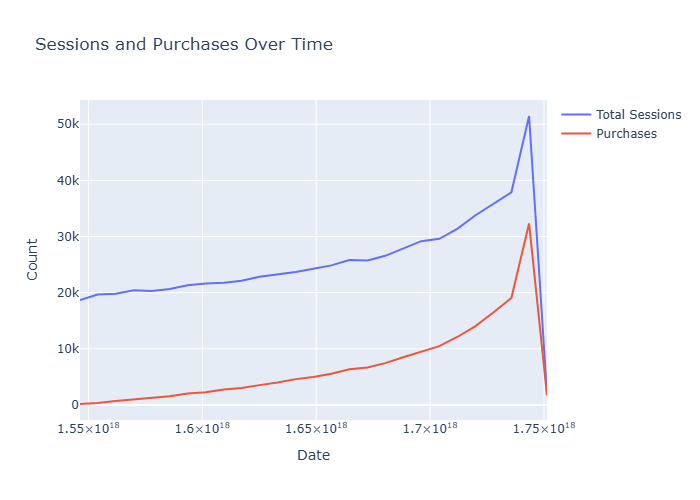

In [10]:
quarterly_stats = dat.groupby('quarter').agg(
    total_sessions=('session_id', 'count'),
    purchases=('purchase_order', lambda x: x.notna().sum())
).reset_index()

fig_session_purchase = go.Figure()
fig_session_purchase.add_trace(go.Scatter(x=quarterly_stats['quarter'], y=quarterly_stats['total_sessions'], mode='lines', name='Total Sessions'))
fig_session_purchase.add_trace(go.Scatter(x=quarterly_stats['quarter'], y=quarterly_stats['purchases'], mode='lines', name='Purchases'))
fig_session_purchase.update_layout(title='Sessions and Purchases Over Time', xaxis_title='Date', yaxis_title='Count')
fig_session_purchase.show()

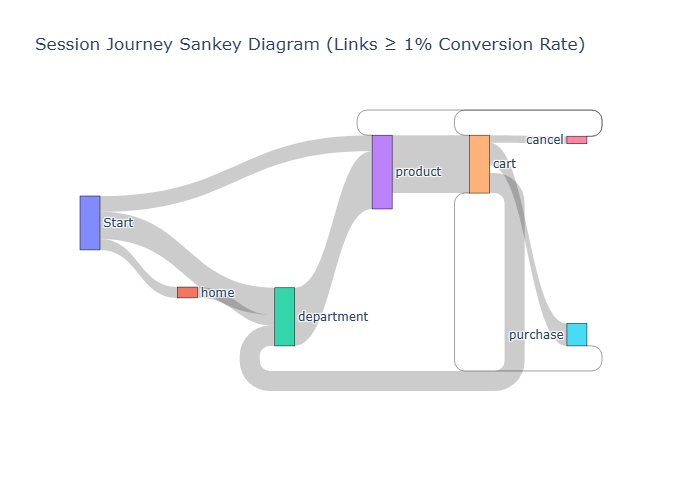

In [11]:
journeys = dat[dat['date'] >= dt.date(2023, 1, 1)]['event_sequence']

desired_order = ['Start', 'home', 'department', 'product', 'cart', 'purchase', 'cancel']

transitions = Counter()
for journey in journeys:
    journey = list(journey)
    transitions[('Start', journey[0])] += 1
    for a, b in zip(journey[:-1], journey[1:]):
        transitions[(a, b)] += 1

# Calculate base counts for each source node
base_counts = Counter()
for (a, b), v in transitions.items():
    base_counts[a] += v

# Filter links by conversion rate threshold (e.g., 1%)
MIN_CONV_RATE = 1.0 
filtered_transitions = {}
for (a, b), v in transitions.items():
    conv_rate = v / base_counts[a] * 100
    if conv_rate >= MIN_CONV_RATE:
        filtered_transitions[(a, b)] = v

# Only keep nodes that are in the desired order and present in filtered_transitions
present_nodes = set()
for a, b in filtered_transitions:
    present_nodes.add(a)
    present_nodes.add(b)
unique_labels = [label for label in desired_order if label in present_nodes]

label_idx = {label: i for i, label in enumerate(unique_labels)}

# Prepare source, target, value, and custom_labels lists
source = []
target = []
value = []
custom_labels = []

for (a, b), v in filtered_transitions.items():
    if a in label_idx and b in label_idx:
        source.append(label_idx[a])
        target.append(label_idx[b])
        value.append(v)
        base = base_counts[a]
        if base > 0:
            rate = v / base * 100
            custom_labels.append(f"{a} → {b}<br>{v} ({rate:.1f}%)")
        else:
            custom_labels.append(f"{a} → {b}<br>{v}")

fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=unique_labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        label=custom_labels
    )
))

fig.update_layout(title_text="Session Journey Sankey Diagram (Links ≥ 1% Conversion Rate)", font_size=12)
fig.show()

From this Sankey Diagram, it is indicative that most users follow a typical path: home -> department -> product -> cart -> purchase, with some drop-off at each stage. Additionally, the largest drop-off points are prime targets for optimization for this business. Test and deploy new features might improve these conversion rates even further.

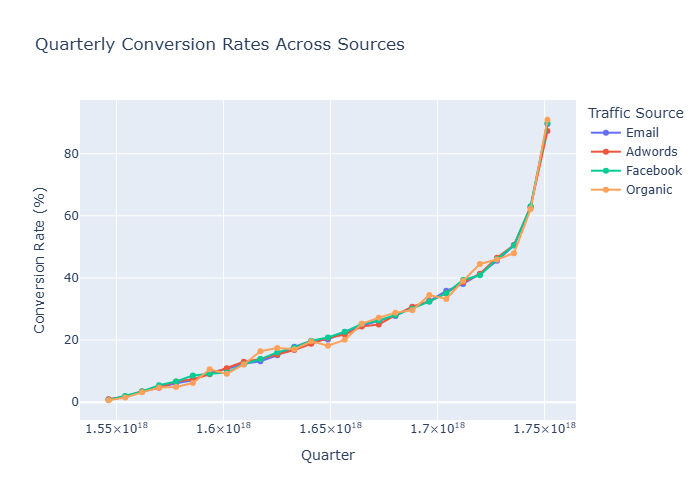

In [12]:
# Define your traffic sources
sources = ['Email', 'Adwords', 'Facebook', 'Youtube', 'Organic']

source_stats = {}

for src in sources:
    stats = dat[dat['first_touch_source'] == src].groupby('quarter').agg(
        total_sessions=('session_id', 'count'),
        purchases=('purchase_order', lambda x: x.notna().sum())
    ).reset_index()
    stats['conversion_rate'] = (stats['purchases'] / stats['total_sessions']) * 100
    source_stats[src] = stats

fig_quarterly = go.Figure()

for i, src in enumerate(sources):
    stats = source_stats[src]
    fig_quarterly.add_trace(go.Scatter(
        x=stats['quarter'],
        y=stats['conversion_rate'],
        mode='lines+markers',
        name=src
    ))

fig_quarterly.update_layout(
    title='Quarterly Conversion Rates Across Sources',
    xaxis_title='Quarter',
    yaxis_title='Conversion Rate (%)',
    legend_title='Traffic Source'
)
fig_quarterly.show()

These suspiciously high and trending-upward conversion rates strongly indicate that the synthetic dataset does not convey accurate enough real-world user behavior and that further analysis will most likely result in incomprehensible results. In addition, this chart of conversion rates across sources highlights the likely insignificant differences between traffic sources' contributions to the business. 

#### Extra visualizations:

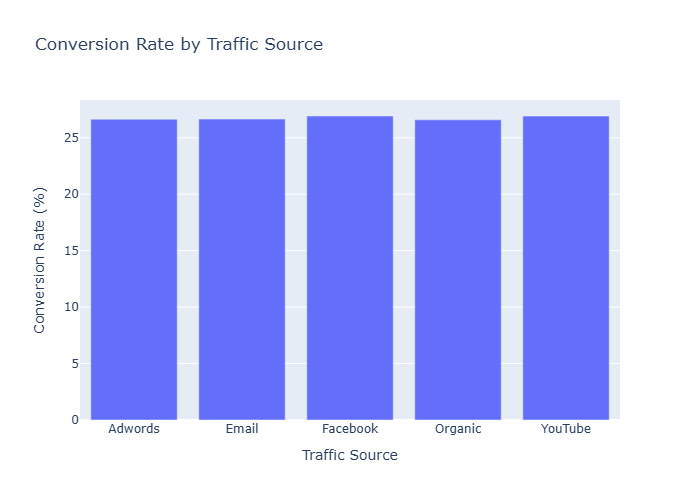

In [13]:
source_stats = dat.groupby('first_touch_source').agg(
    total_sessions = ('session_id', 'count'),
    purchases = ('purchase_order', lambda x: x.notna().sum())
)
source_stats['conversion_rate'] = (source_stats['purchases'] / source_stats['total_sessions']) * 100
source_stats = source_stats.reset_index()

fig_bar = px.bar(
    source_stats,
    x='first_touch_source',
    y='conversion_rate',
    title='Conversion Rate by Traffic Source',
    labels={'conversion_rate': 'Conversion Rate (%)', 'first_touch_source': 'Traffic Source'}
)
fig_bar.show()

As mentioned above, the contribution hardly differs from sources to sources, meaning that no traffic source is more effective at gaining new purchases.

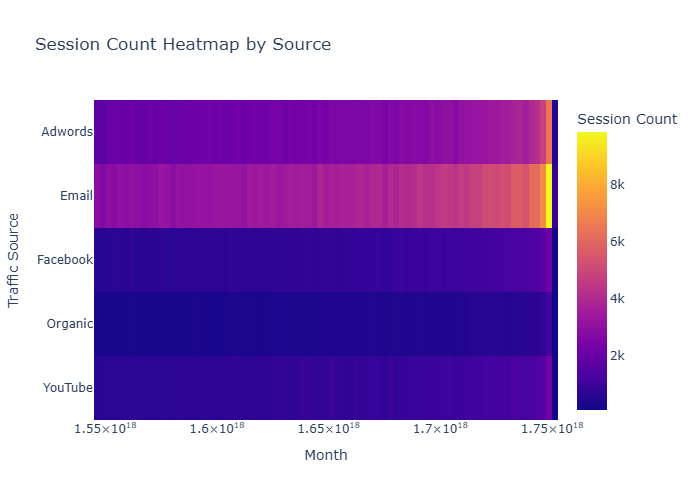

In [14]:
pivot = dat.pivot_table(
    index='first_touch_source',
    columns='month',
    values='session_id',
    aggfunc='count'
)

fig = px.imshow(
    pivot,
    labels=dict(x="Month", y="Traffic Source", color="Session Count"),
    title="Session Count Heatmap by Source"
)
fig.show()

There seems to be a small spike in session count every February for Adwords, Email, Facebook, and Youtube. Organic seems to harbor the same pattern yet its effect is almost unnoticeable. In June 2025, there is an extreme spike for Email, potentially signaling a successful marketing campaign for that type of traffic source.

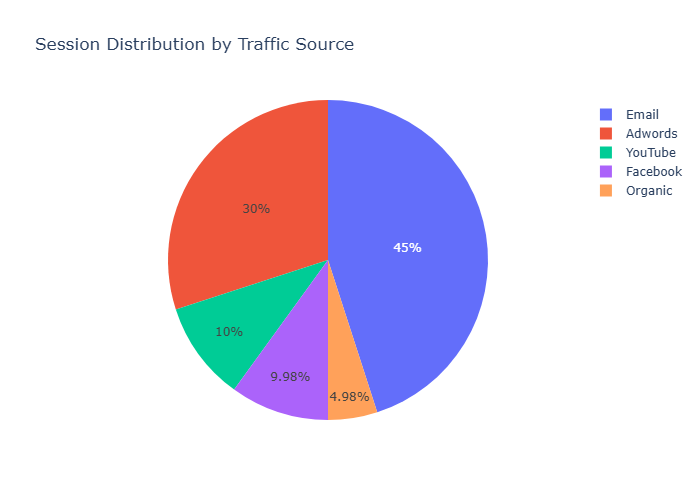

In [15]:
source_counts = dat.groupby('first_touch_source').agg(
    sessions=('session_id', 'count'),
).reset_index()

fig = px.pie(
    source_counts,
    names='first_touch_source',
    values='sessions',
    title='Session Distribution by Traffic Source'
)
fig.show()

This chart specifically highlights the contributions from different traffic sources, with Email being the biggest contributor.